#### Data Preparation and Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv(r"C:\Users\Parvathy Shine\Desktop\Assignments\20. Timeseries\Timeseries\exchange_rate.csv")
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [2]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

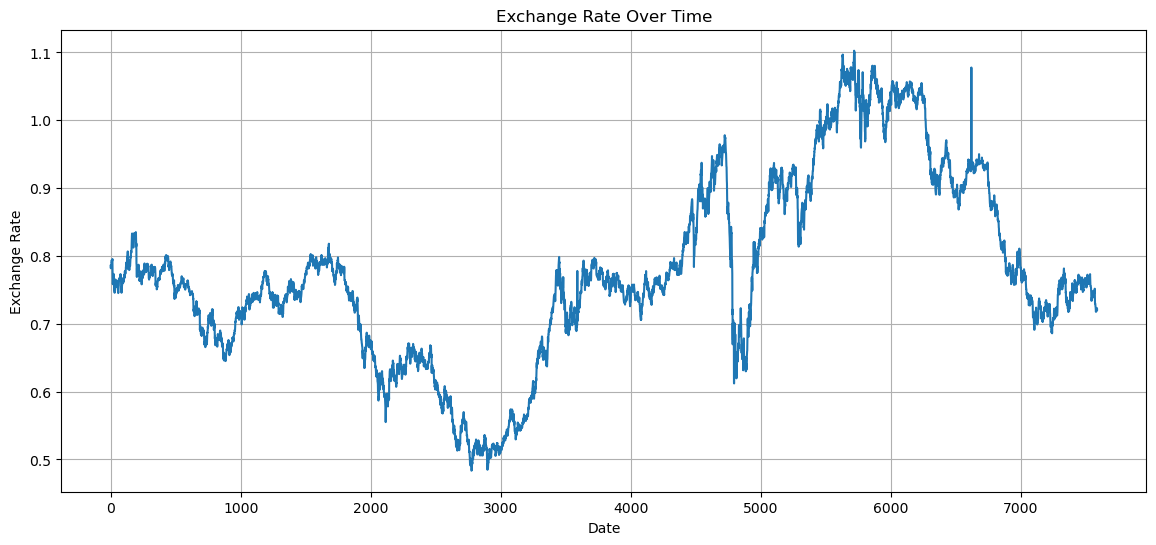

In [5]:
# Plot the timeseries

df['Ex_rate'].plot(figsize=(14,6), title='Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

# we can see major rise after 2005
# it dips majorly in between 1995 -2000

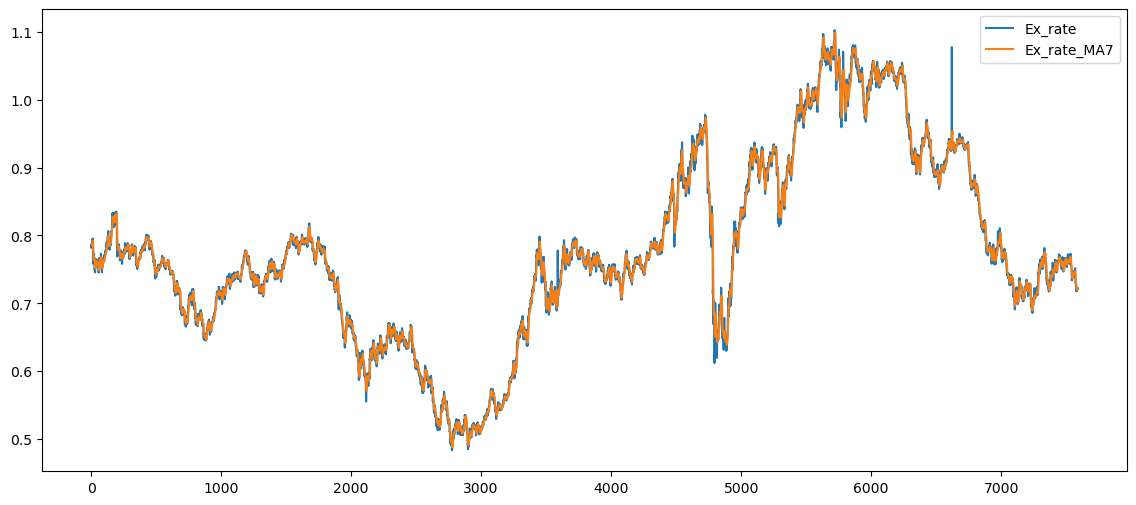

In [6]:
df['Ex_rate_MA7'] = df['Ex_rate'].rolling(window=7).mean()
df[['Ex_rate', 'Ex_rate_MA7']].plot(figsize=(14,6))
plt.show()

In [7]:
# Parse the date column, specifying the correct format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M') # Specify the format as day-month-year hour:minute
df.set_index('date', inplace=True)

#### Model Building - ARIMA

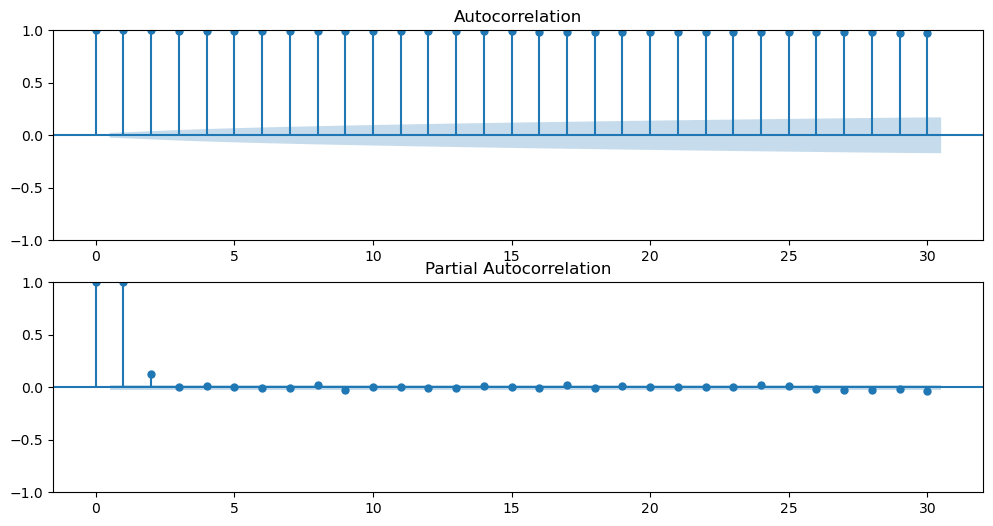

In [8]:
# 1. To estimate the initial parameters (p, d, q) for the ARIMA model, we will utilize ACF and PACF plots.
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(df['Ex_rate'], lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Ex_rate'], lags=30, ax=ax[1])
plt.show()

In [9]:
# 2. Model Fitting 

# Since we estimated ARIMA(p=1, d=1, q=1) 
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Ex_rate'], order=(1, 1, 1)) # Order=(p,d,q) is selected based on ACF/PACF
arima_result = model.fit() 
print(arima_result.summary())

C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 29 May 2025   AIC                         -56102.322
Time:                        16:09:54   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

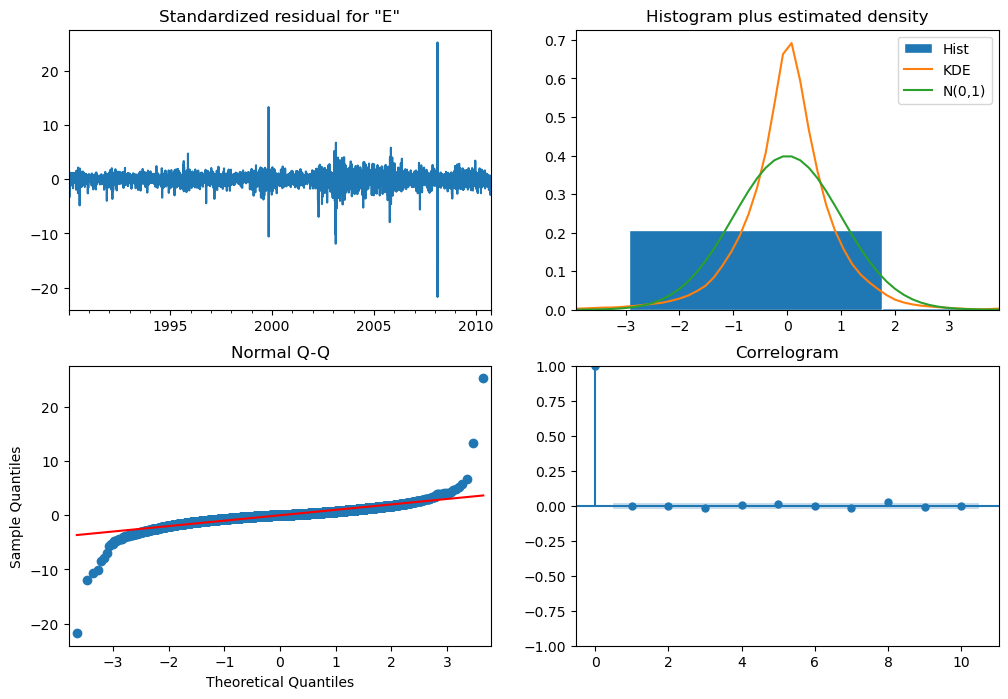

In [10]:
# Diagnostics:  To ensure that the ARIMA model is adequate, we need to analyze the residuals.
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

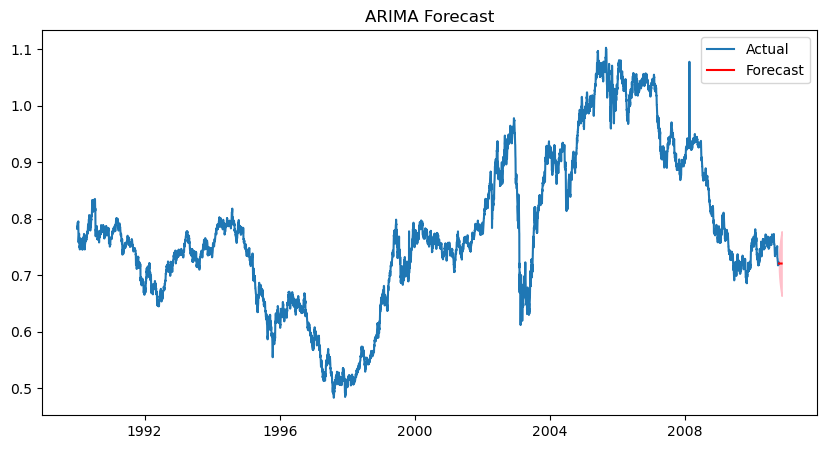

In [11]:
# Forecast
forecast = arima_result.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

#### Model Building - Exponential Smoothing

C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


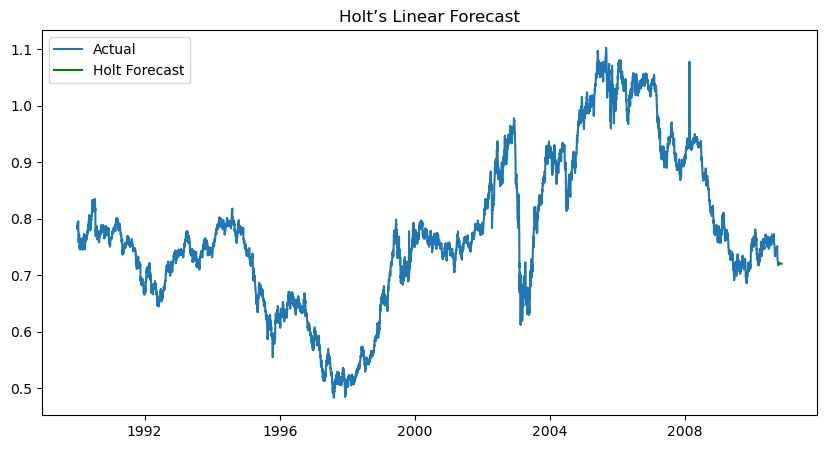

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Model
holt = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()
holt_forecast = holt.forecast(30)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(holt_forecast, label='Holt Forecast', color='green')
plt.legend()
plt.title('Holt’s Linear Forecast')
plt.show()


#### Evaluation and Comparison

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Create test data (e.g., last 30 days)
train = df.iloc[:-30]
test = df.iloc[-30:]

# ARIMA forecast
arima_model = ARIMA(train['Ex_rate'], order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(30)

# Holt forecast
holt_model = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(30)

# Metrics
def get_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = get_metrics(test['Ex_rate'], arima_forecast)
holt_mae, holt_rmse, holt_mape = get_metrics(test['Ex_rate'], holt_forecast)

print("ARIMA - MAE:", arima_mae, "RMSE:", arima_rmse, "MAPE:", arima_mape)
print("Holt - MAE:", holt_mae, "RMSE:", holt_rmse, "MAPE:", holt_mape)


C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Parvathy Shine\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA - MAE: 0.013494600805702773 RMSE: 0.016632177912475444 MAPE: 1.863220748533125
Holt - MAE: 0.01342527852019549 RMSE: 0.016499780609106198 MAPE: 1.8534530006510028


In [14]:
# Mean Absolute Error - Holts prediction are better 
# Root mean squared error - Both are close, but Holts has slightly lower error 
# Mean absolute percentage error= holt is better 

##### ARIMA Model
Advantages: Handles non-stationarity and seasonality
<br>Limitations: Computationally expensive, requires careful parameter selection(q,p and d)

##### Holt's Linear Trend Model
Advantages: Simple, computationally efficient
<br>Limitations: Assumes linear trend, no seasonality

both models assume the future behave like the past.

##### Conclusion :
In this study, both ARIMA and Holt’s Linear Trend models proved effective in forecasting the USD to AUD exchange rates, achieving low error rates across all evaluation metrics. While the differences were minimal, Holt’s Linear model slightly outperformed ARIMA, with a lower MAE (0.01343), RMSE (0.01650), and MAPE (1.85%).